In [1]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov, solver_eigen_scipy, solver_iter_pcg
from skfem.helpers import dd, ddot, div, grad
from scipy.sparse.linalg import LinearOperator, minres
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import bmat
import dmsh
from skfem.assembly import BilinearForm, LinearForm
plt.rcParams['figure.dpi'] = 100

## Begin equation

$$
- \Delta\boldsymbol{u} + \nabla p = \boldsymbol{f} \ in \  \Omega
$$

$$
\nabla\cdot\boldsymbol{u} = 0 \ in \  \Omega
$$

$$
u = 0 \ on \ \partial \Omega
$$
where 

$$
\left\{\begin{array}{l}
\Delta \mathbf{u}=\sum_{i=1}^{N} \frac{\partial^{2} \mathbf{u}}{\partial x_{i} \partial x_{i}} \\
\nabla p=\left(\frac{\partial p}{\partial x_{1}}, \frac{\partial p}{\partial x_{2}}, \ldots, \frac{\partial p}{\partial x_{N}}\right) \\
\nabla \cdot \mathbf{u}=\sum_{1}^{N} \frac{\partial u_{i}}{\partial x_{i}}
\end{array}\right.
$$

`u` is the velocity vector and `p` is the pressure

`basis.find_dofs()` almost equals to `m.boundary_nodes()`

$$
\left(\begin{array}{cc}
A & -B \\
B^{T} & 0
\end{array}\right)\left(\begin{array}{l}
U \\
P
\end{array}\right)=\left(\begin{array}{l}
F_{1} \\
0
\end{array}\right)
$$

## $(P_2,P_1)$ Taylor-Hood element: Optimal convergent rate

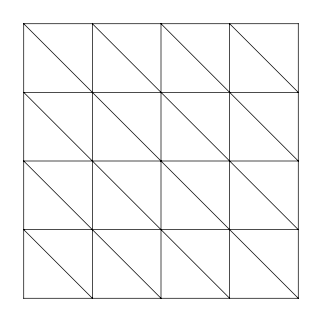

In [21]:
# mesh = MeshTri(*map(np.transpose, dmsh.generate(dmsh.Circle([0., 0.], 1.), .7))) 

mesh = MeshTri()
mesh.refine(2)

element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP0()}
basis = {variable: InteriorBasis(mesh, e, intorder=4) 
         for variable, e in element.items()} # intorder: integration order for quadrature

draw(mesh)

In [2]:
@BilinearForm
def vector_laplace(u, v, w):
    '''
    a
    '''
    return ddot(grad(u), grad(v))


@BilinearForm
def divergence(u, v, w):
    '''
    b
    '''
    return div(u) * v


@LinearForm
def body_force(v, w):
    '''
    for f.*v
    '''
    x, y = w.x
    # print(x==w.x[0])
    # print(y==w.x[1])

    f1 = 10 * (12 * x**2 - 12 * x + 2) * y * (y - 1) * (2 * y - 1) + 10 * (x**2) * ((x - 1)**2) * (12 * y - 6) + 2 * x
    f2 = -(10 * (12 * y**2 - 12 * y + 2) * x * (x - 1) * (2 * x - 1) + 10 * (y**2) * ((y - 1)**2) * (12 * x - 6)) - 2 * y
    # print(f1.shape)
    # print(v.value[1].shape)
    # return np.array([[f1 * v.value[0]], [f2 * v.value[1]]])
    return f1 * v.value[0] + f2 * v.value[1]


@BilinearForm
def mass(u, v, w):
    return u * v

In [23]:
A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

In [24]:
A.shape

(162, 162)

In [25]:
B.shape

(25, 162)

In [26]:
%%time
up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

Wall time: 9.78 ms


In [27]:
u, p = np.split(up, [A.shape[0]])
U = basis['u'].interpolate(u)

# uh = U.value
# uh.shape
# x = basis['u'].global_coordinates().value
# x.shape

In [28]:
u.shape

(162,)

In [29]:
p.shape

(25,)

## Error estimating

### $L2$ error of $p$

In [3]:
def exactp(x, y):
    return x**2 - y**2

@Functional
def L2Error_p(w):
    x, y = w.x
    return (w.w - exactp(x,y))**2

In [15]:
# basis['p'].doflocs

# ph.shape
# p.shape

# (np.sqrt(np.sum((p-ph)**2)))/len(ph)

In [34]:
basis['p'].interpolate(ph)

DiscreteField(value=array([[ 3.03443924e-07,  3.03443924e-07,  3.03443924e-07,
         3.03443924e-07,  3.03443924e-07,  3.03443924e-07],
       [ 9.67285536e-01,  9.67285536e-01,  9.67285536e-01,
         9.67285536e-01,  9.67285536e-01,  9.67285536e-01],
       [ 9.49884352e-01,  9.49884352e-01,  9.49884352e-01,
         9.49884352e-01,  9.49884352e-01,  9.49884352e-01],
       ...,
       [-8.45322458e-07, -8.45322458e-07, -8.45322458e-07,
        -8.45322458e-07, -8.45322458e-07, -8.45322458e-07],
       [-1.00085249e-06, -1.00085249e-06, -1.00085249e-06,
        -1.00085249e-06, -1.00085249e-06, -1.00085249e-06],
       [ 6.07224334e-07,  6.07224334e-07,  6.07224334e-07,
         6.07224334e-07,  6.07224334e-07,  6.07224334e-07]]), grad=array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.,

In [33]:
formerL2p = 1
currentL2p = 1
for i in range(6):
    mesh = MeshTri()
    mesh.refine(i)
    element = {'u': ElementVectorH1(ElementTriP2()),
               'p': ElementTriP0()}
    basis = {variable: InteriorBasis(mesh, e, intorder=4) 
             for variable, e in element.items()} # intorder: integration order for quadrature

    A = asm(vector_laplace, basis['u'])
    B = asm(divergence, basis['u'], basis['p'])
    C = asm(mass, basis['p'])

    K = bmat([[A, -B.T],
              [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
    f = np.concatenate([asm(body_force, basis['u']),
                        np.zeros(B.shape[0])])

    up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

    uh, ph = np.split(up, [A.shape[0]])
#     p = exactp(basis['p'].doflocs[0], basis['p'].doflocs[1])
#     print((np.sqrt(np.sum((p-ph)**2)))/len(ph))
    P = basis['p'].interpolate(ph).value
    L2p = np.sqrt(L2Error_p.assemble(basis['p'], w=P))
    print('2^-'+str(i+1)+' case')
    print('L2p', L2p)
    currentL2p = L2p
    if i!= 0:
        print('rate', -np.log2(currentL2p/formerL2p))
    formerL2p = L2p

2^-1 case
L2p 0.4216370213557847
2^-2 case
L2p 0.2280234998836702
rate 0.8868190319002364
2^-3 case
L2p 0.11518309477442656
rate 0.9852535243856813
2^-4 case
L2p 0.05713921961991817
rate 1.011375752552701
2^-5 case
L2p 0.028372735239650754
rate 1.0099760941624065
2^-6 case
L2p 0.014136382988075671
rate 1.0050922070537345


### Visualizing $p$ and $ph$

### Trying `P1CR`

In [22]:
class ElementTriP1CR(ElementHdiv):

    nodal_dofs = 1
    dim = 2
    maxdeg = 1
    dofnames = ['u']
    doflocs = np.array([[0., 0.5],
                        [0.5, 0.],
                        [0.5, 0.5]])
    mesh_type = MeshTri

    def lbasis(self, X, i):
        x, y = X

        if i == 0:
            phi = 1. - 2. * x
            dphi = np.array([-2. + 0. * x, 0. * x])
        elif i == 1:
            phi = 1. - 2. * y
            dphi = np.array([ 0. * x, -2. + 0. * y])
        elif i == 2:
            phi = 2. * x + 2. * y - 1.
            dphi = np.array([2. + 0. * x, 2. + 0. * y])
        else:
            self._index_error()

        return phi, dphi

In [24]:
mesh = MeshTri()
mesh.refine(5)
element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP0()}
basis = {variable: InteriorBasis(mesh, e, intorder=4) 
         for variable, e in element.items()} # intorder: integration order for quadrature

A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

uh, ph = np.split(up, [A.shape[0]])
P = basis['p'].interpolate(ph).value
L2p = np.sqrt(L2Error_p.assemble(basis['p'], w=P))
print('L2p', L2p)

L2p 0.014136382988075671


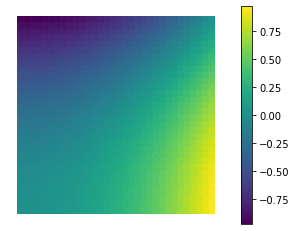

In [25]:
plot(basis['p'], ph, colorbar=True)

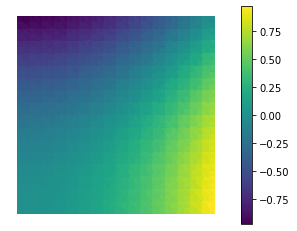

In [26]:
p = exactp(basis['p'].doflocs[0], basis['p'].doflocs[1])
plot(basis['p'], p, colorbar=True)

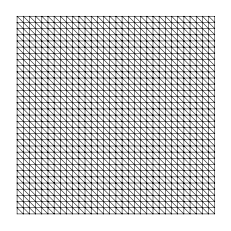

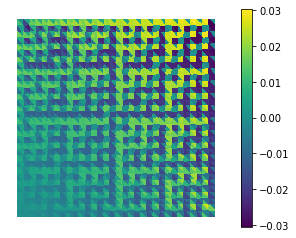

In [27]:
draw(mesh)
plot(basis['p'], p-ph, colorbar=True)

### u

In [52]:
def exactu(x, y):
    u1 = 10*(x**2)*((x-1)**2)*y*(y-1)*(2*y-1)
    u2 = -10*(y**2)*((y-1)**2)*x*(x-1)*(2*x-1)
    return u1, u2

@Functional
def L2Error_u(w):
    x, y = w.x
    u1, u2 = exactu(x, y)
#     print((w.w[0] - u1)**2)
#     print((w.w[1] - u2)**2)
    return (w.w[0] - u1)**2 + (w.w[1] - u2)**2

L2 Error: 0.07074346366960212


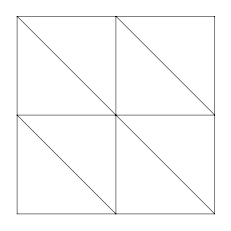

In [59]:
mesh = MeshTri()
mesh.refine(1)

element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP1()}
basis = {variable: InteriorBasis(mesh, e, intorder=4) 
         for variable, e in element.items()} # intorder: integration order for quadrature

A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

u, p = np.split(up, [A.shape[0]])

U = basis['u'].interpolate(u)
L2u = np.sqrt(L2Error_u.assemble(basis['u'], w=U))

print('L2 Error:', L2u)

draw(mesh)

## Direct error

In [66]:
mesh = MeshTri()
mesh.refine(1)
element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP1()}
basis = {variable: InteriorBasis(mesh, e, intorder=4) 
         for variable, e in element.items()} # intorder: integration order for quadrature

A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

u, p = np.split(up, [A.shape[0]])

In [67]:
u1, u2 = exactu(basis['u'].doflocs[0][::2], basis['u'].doflocs[1][::2]) 

uh1 = u[::2]
uh2 = u[1::2]

# np.sum((u2 - uh2/2)**2 + (u1 - uh1/2)**2)/u2.shape[0]
np.sum((u2 - uh2/2)**2)/u2.shape[0]

0.0009310298622520477

In [68]:
np.sum((u1 - uh1/2)**2)/u2.shape[0]

0.0009310298622325233

In [354]:
u

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.87748586e-07,  1.87748616e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.77562201e-02, -4.77559413e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.77559413e-02,  4.77562201e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.57075232e-02,  4.57075232e-02,
       -7.06763778e-02,  2.04865964e-03, -2.04865965e-03,  7.06763778e-02,
        2.04843848e-03, -7.06760316e-02,  7.06760316e-02, -2.04843847e-03,
        4.57073693e-02, -4.57073693e-02])

In [353]:
# for i in range(len(u)):
#     print(u[i])


In [350]:
u1

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.03295898,  0.        , -0.        ,
       -0.03295898,  0.        , -0.        ,  0.        ,  0.03295898,
        0.05859375, -0.        , -0.        , -0.05859375, -0.03295898])

In [351]:
# uh1

In [352]:
u2

array([-0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.03295898, -0.        , -0.        ,
       -0.03295898, -0.        , -0.        ,  0.        , -0.03295898,
        0.        , -0.05859375,  0.05859375,  0.        ,  0.03295898])

In [331]:
# uh2

### Analysising

In [ ]:
A.shape

In [ ]:
B.shape

In [ ]:
C.todense() # sparse to dense

## Solving the stream function $\psi$
from $$-\Delta \psi=\operatorname{rot} \boldsymbol{u}$$

In [ ]:
# @LinearForm
# def rot(v, w):
#     return np.einsum('i...,ij...,j...',
#                      w.w, np.array([[0, 1], [-1, 0]]), grad(v)

In [ ]:
# basis['psi'] = InteriorBasis(mesh, ElementTriP2())
# A = asm(laplace, basis['psi'])

# vorticity = asm(rot, basis['psi'], w=[basis['psi'].interpolate(velocity[i::2]) for i in range(2)])
# psi = solve(*condense(A, vorticity, D=basis['psi'].find_dofs()), solver=solver_iter_pcg())

## Visualization

In [ ]:
# from matplotlib.tri import Triangulation
# from skfem.visuals.matplotlib import plot, draw

# print(basis['psi'].interpolator(psi)(np.zeros((2, 1)))[0],
#       '(cf. exact 1/64)')

# print(basis['p'].interpolator(pressure)(np.array([[-0.5, 0.5],
#                                                   [0.5, 0.5]])),
#       '(cf. exact -/+ 1/8)')

# ax = draw(mesh)
# plot(basis['p'], pressure, ax=ax, colarbar = True)

# ax = draw(mesh)
# velocity1 = velocity[basis['u'].nodal_dofs]
# ax.quiver(*mesh.p, *velocity1, mesh.p[0, :])  # colour by buoyancy

# ax = draw(mesh)
# ax.tricontour(Triangulation(*mesh.p, mesh.t.T),
#               psi[basis['psi'].nodal_dofs.flatten()])

## Trying $(P_1,P_0)$ 

In [154]:
formerL2p = 1
currentL2p = 1
for i in range(5):
    mesh = MeshTri()
    mesh.refine(i)
    element = {'u': ElementVectorH1(ElementTriP2()),
               'p': ElementTriP0()}
    basis = {variable: InteriorBasis(mesh, e, intorder=4) 
             for variable, e in element.items()} # intorder: integration order for quadrature

    A = asm(vector_laplace, basis['u'])
    B = asm(divergence, basis['u'], basis['p'])
    C = asm(mass, basis['p'])

    K = bmat([[A, -B.T],
              [-B, 1e-6 * C]], 'csr') # get the sparse format of the result by 'csr'
    f = np.concatenate([asm(body_force, basis['u']),
                        np.zeros(B.shape[0])])

    up = solve(*condense(K, f, D=basis['u'].find_dofs()), solver=solver_iter_pcg())

    uh, ph = np.split(up, [A.shape[0]])
#     p = exactp(basis['p'].doflocs[0], basis['p'].doflocs[1])
#     print((np.sqrt(np.sum((p-ph)**2)))/len(ph))
    P = basis['p'].interpolate(ph).value
    L2p = np.sqrt(L2Error_p.assemble(basis['p'], w=P))
    print('2^-'+str(i+1)+' case \n')
    print('L2p', L2p)
    currentL2p = L2p
    if i!= 0:
        print('rate', -np.log2(currentL2p/formerL2p))
    formerL2p = L2p

2^-1 case 

L2p 0.4216370213557847
2^-2 case 

L2p 0.2280234998836702
rate 0.8868190319002364
2^-3 case 

L2p 0.11518309477442656
rate 0.9852535243856813
2^-4 case 

L2p 0.05713921961991817
rate 1.011375752552701
2^-5 case 

L2p 0.028372735239650754
rate 1.0099760941624065


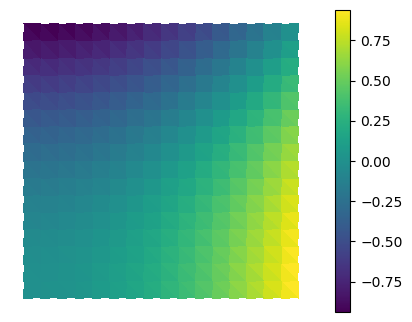

In [155]:
plot(basis['p'], ph, colorbar=True)

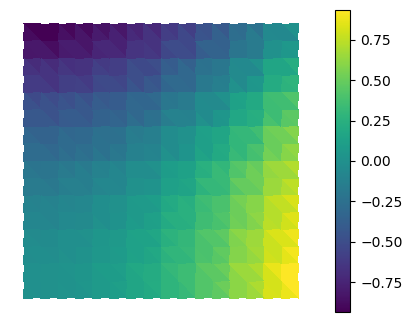

In [156]:
p = exactp(basis['p'].doflocs[0], basis['p'].doflocs[1])
plot(basis['p'], p, colorbar=True)

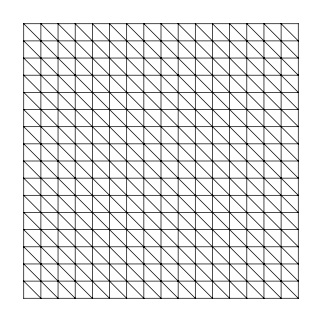

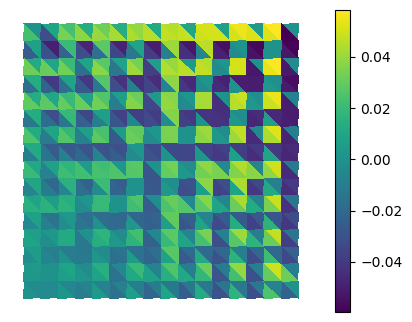

In [157]:
draw(mesh)
plot(basis['p'], p - ph, colorbar=True)